### create twomoon data sample

In [49]:
import numpy as np
import math
from sklearn.datasets import make_moons
from scipy.stats import norm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [50]:
# Create a simple dataset
def create_twomoon_dataset(n, p):
    relevant, y = make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
    noise_vector = norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y

In [51]:
n_size = 1000   # Number of samples
p_size = 20     # Number of features
X_data, y_data = create_twomoon_dataset(n_size, p_size)

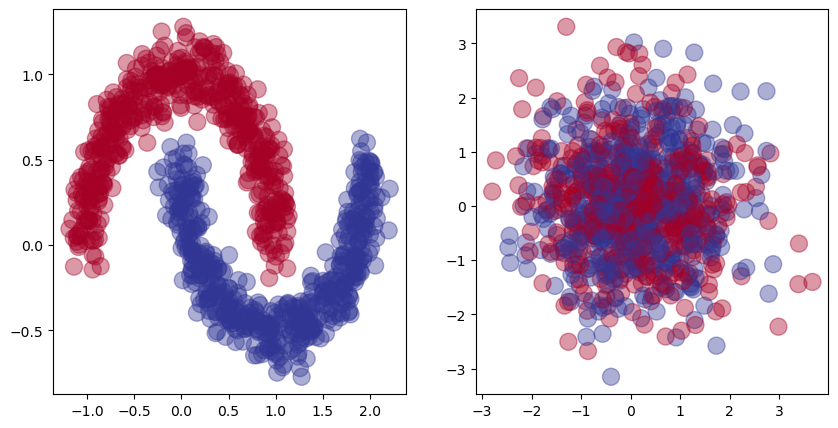

In [52]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        
# feature간 상관관계 plot
# 0 1 relevant / else noise
ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, 
        c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].scatter(x=X_data[:,2], y=X_data[:,3], s=150, 
        c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)

plt.tick_params(labelsize=10)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((640, 20), (160, 20), (640,), (160,))

In [54]:
y_train = y_train.reshape(640,1)
y_valid = y_valid.reshape(160,1)

In [55]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = torch.Tensor(self.y[idx])
        return x, y

In [56]:
from torch.utils.data import DataLoader

train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = CustomDataset(X_valid, y_valid)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### STG Model

In [57]:
import torch
import torch.nn as nn

In [58]:
# Gaussian CDF function
a = torch.Tensor([1,2,3,4,5])
print(a)
print(a/math.sqrt(2))
print(torch.erf(a / math.sqrt(2)))
print(1 + torch.erf(a / math.sqrt(2)))
print(0.5 * (1 + torch.erf(a / math.sqrt(2))))
0.5 * (1 + torch.erf(a / math.sqrt(2)))

tensor([1., 2., 3., 4., 5.])
tensor([0.7071, 1.4142, 2.1213, 2.8284, 3.5355])
tensor([0.6827, 0.9545, 0.9973, 0.9999, 1.0000])
tensor([1.6827, 1.9545, 1.9973, 1.9999, 2.0000])
tensor([0.8413, 0.9772, 0.9987, 1.0000, 1.0000])


tensor([0.8413, 0.9772, 0.9987, 1.0000, 1.0000])

In [59]:
class FeatureSelector(nn.Module):
    def __init__(self, input_dim=20):
        super(FeatureSelector, self).__init__()
        self.mu = torch.nn.Parameter(0.01*torch.randn(input_dim, ), requires_grad=True)
        self.noise = torch.randn(self.mu.size()) 
        self.sigma = 0.5    # noise 강도 임의 설정
    
    def forward(self, prev_x):
        z = self.mu + self.sigma*self.noise.normal_()*self.training 
        stochastic_gate = self.hard_sigmoid(z)
        new_x = prev_x * stochastic_gate
        return new_x
    
    def hard_sigmoid(self, x):
        return torch.clamp(x+0.5, 0.0, 1.0)

    def regularizer(self, x):
        ''' Gaussian CDF. '''
        # torch.erf(x / math.sqrt(2))
        return 0.5 * (1 + torch.erf(x / math.sqrt(2))) 

In [60]:
class FeatureSelector2(nn.Module):
    def __init__(self, input_dim=20, mu=0.5):
        super(FeatureSelector2, self).__init__()
        self.mu = mu + torch.nn.Parameter(0.01*torch.randn(input_dim, ), requires_grad=True)
        self.noise = torch.randn(self.mu.size()) 
        self.sigma = 0.5    # noise 강도 임의 설정
    
    def forward(self, prev_x):
        z = self.mu + self.sigma*self.noise.normal_()*self.training 
        stochastic_gate = self.hard_sigmoid(z)
        new_x = prev_x * stochastic_gate
        new_x = prev_x
        return new_x
    
    def hard_sigmoid(self, x):
        return torch.clamp(x, 0.0, 1.0)

    def regularizer(self, x):
        ''' Gaussian CDF. '''
        # torch.erf(x / math.sqrt(2))
        return 0.5 * (1 + torch.erf(x / math.sqrt(2))) 

In [61]:
class STGNet(nn.Module):
    def __init__(self):
        super(STGNet, self).__init__()

        self.layer1 = nn.Linear(20, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.sig(x)
        
        return x

In [62]:
net = STGNet()

In [63]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [64]:
fs = FeatureSelector()
fs2 = FeatureSelector2()

### train : original

In [65]:
# original

epochs = 200

for epoch in range(epochs):
    cost_o = 0.0
    net.train()

    for i, (x, y) in enumerate(train_dataloader):

        # original
        pred = net(x)

        loss_origin = criterion(pred, y)

        optimizer.zero_grad()
        loss_origin.backward()
        optimizer.step()

        cost_o += loss_origin

    cost_o = cost_o / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost Original : {cost_o:.3f}")

Epoch :   10,  Cost Original : 0.506
Epoch :   20,  Cost Original : 0.383
Epoch :   30,  Cost Original : 0.333
Epoch :   40,  Cost Original : 0.304
Epoch :   50,  Cost Original : 0.286
Epoch :   60,  Cost Original : 0.277
Epoch :   70,  Cost Original : 0.272
Epoch :   80,  Cost Original : 0.270
Epoch :   90,  Cost Original : 0.270
Epoch :  100,  Cost Original : 0.269
Epoch :  110,  Cost Original : 0.269
Epoch :  120,  Cost Original : 0.269
Epoch :  130,  Cost Original : 0.269
Epoch :  140,  Cost Original : 0.269
Epoch :  150,  Cost Original : 0.269
Epoch :  160,  Cost Original : 0.269
Epoch :  170,  Cost Original : 0.269
Epoch :  180,  Cost Original : 0.269
Epoch :  190,  Cost Original : 0.269
Epoch :  200,  Cost Original : 0.269


In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [67]:
net.eval()
pred_y = np.array([])

for idx, (x, y) in enumerate(test_dataloader):

    pred = net(x)
    pred = pred.detach().numpy()
    y = y.detach().numpy()

    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0

    acc = accuracy_score(y, pred)

    if idx==0:
        data_x = x
    else :
        data_x = torch.cat([data_x, x])
        
    pred_y = np.append(pred_y, np.array(pred))
    

print('Accuracy was : {}'.format(np.mean(acc)))
print(confusion_matrix(y, pred))
print(classification_report(y, pred))

Accuracy was : 0.875
[[16  1]
 [ 3 12]]
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89        17
         1.0       0.92      0.80      0.86        15

    accuracy                           0.88        32
   macro avg       0.88      0.87      0.87        32
weighted avg       0.88      0.88      0.87        32



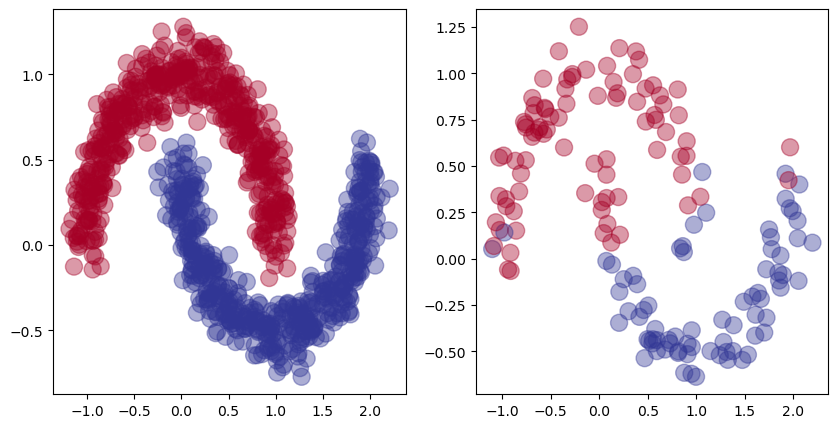

In [68]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        
ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, 
        c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].scatter(x=data_x[:,0], y=data_x[:,1], s=150, 
        c=pred_y,alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)

plt.tick_params(labelsize=10)

### train : feature selection

In [69]:
net = STGNet()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [70]:
# feature selection

epochs = 200

for epoch in range(epochs):
    cost_fs = 0.0
    net.train()

    for i, (x, y) in enumerate(train_dataloader):

        fs_x = fs(x)
        pred_fs = net(fs_x)

        loss_fs = criterion(pred_fs, y)

        optimizer.zero_grad()
        loss_fs.backward()
        optimizer.step()

        cost_fs += loss_fs

    cost_fs = cost_fs / len(train_dataloader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d},  Cost Feature Selection : {cost_fs:.3f}")


Epoch :   10,  Cost Feature Selection : 0.586
Epoch :   20,  Cost Feature Selection : 0.510
Epoch :   30,  Cost Feature Selection : 0.496
Epoch :   40,  Cost Feature Selection : 0.429
Epoch :   50,  Cost Feature Selection : 0.461
Epoch :   60,  Cost Feature Selection : 0.464
Epoch :   70,  Cost Feature Selection : 0.427
Epoch :   80,  Cost Feature Selection : 0.417
Epoch :   90,  Cost Feature Selection : 0.377
Epoch :  100,  Cost Feature Selection : 0.428
Epoch :  110,  Cost Feature Selection : 0.376
Epoch :  120,  Cost Feature Selection : 0.382
Epoch :  130,  Cost Feature Selection : 0.384
Epoch :  140,  Cost Feature Selection : 0.451
Epoch :  150,  Cost Feature Selection : 0.414
Epoch :  160,  Cost Feature Selection : 0.385
Epoch :  170,  Cost Feature Selection : 0.404
Epoch :  180,  Cost Feature Selection : 0.391
Epoch :  190,  Cost Feature Selection : 0.373
Epoch :  200,  Cost Feature Selection : 0.356


In [71]:
net.eval()
pred_y = np.array([])
data_x

for idx, (x, y) in enumerate(test_dataloader):

    pred = net(x)
    pred = pred.detach().numpy()
    y = y.detach().numpy()

    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0

    acc = accuracy_score(y, pred)

    if idx==0:
        data_x = x
    else :
        data_x = torch.cat([data_x, x])
        
    pred_y = np.append(pred_y, np.array(pred))
    

print('Accuracy was : {}'.format(np.mean(acc)))
print(confusion_matrix(y, pred))
print(classification_report(y, pred))

Accuracy was : 0.84375
[[ 9  1]
 [ 4 18]]
              precision    recall  f1-score   support

         0.0       0.69      0.90      0.78        10
         1.0       0.95      0.82      0.88        22

    accuracy                           0.84        32
   macro avg       0.82      0.86      0.83        32
weighted avg       0.87      0.84      0.85        32



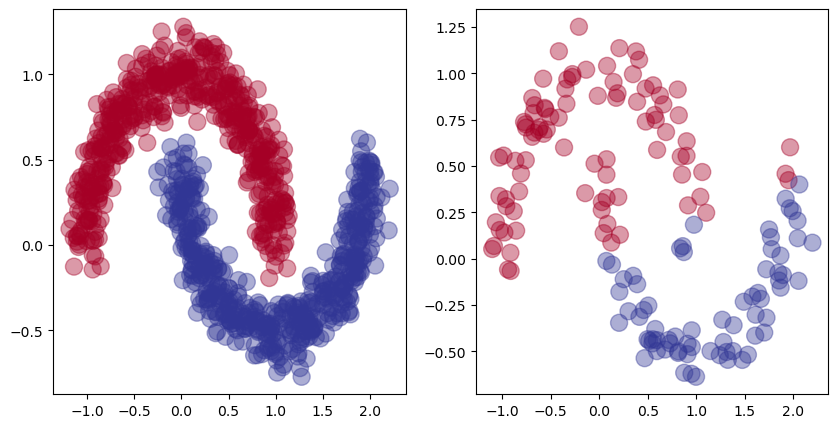

In [72]:
f,ax = plt.subplots(1,2,figsize=(10,5))
        
ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, 
        c=y_data.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
ax[1].scatter(x=data_x[:,0], y=data_x[:,1], s=150, 
        c=pred_y,alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)

plt.tick_params(labelsize=10)